# Landsat on AWS w/ Dask

In [1]:
import os
import glob

import satsearch.main as main
import rasterio
import geopandas as gpd
import pandas as pd
import dask
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

from dask_kubernetes import KubeCluster
from dask.distributed import Client
from dask.distributed import wait, progress

%matplotlib inline

In [2]:
# Print versions
print('Xarray version: ', xr.__version__)
print('Dask version: ', dask.__version__)
print('Rasterio version: ', rasterio.__version__)
print('Geopandas version: ', gpd.__version__)

Xarray version:  0.10.8
Dask version:  0.18.2
Rasterio version:  1.0rc5
Geopandas version:  0.4.0


In [3]:
# Set environment variables for cloud-optimized-geotiff efficiency
os.environ['GDAL_DISABLE_READDIR_ON_OPEN']='YES'
os.environ['CURL_CA_BUNDLE']='/etc/ssl/certs/ca-certificates.crt'
os.environ['CPL_VSIL_CURL_ALLOWED_EXTENSIONS']='TIF'

In [4]:
# Scenes from particular row, col are on same UTM grid
# Programmatic:
search_params = dict(date_from='2017-04-30',
                     date_to = '2018-04-30',
                     satellite_name = 'landsat-8',
                     row=27,
                     path=47,
                     contains='-122.335167,47.608013',
                     )
scenes = main.main(**search_params)
scenes.print_scenes()
scenes.save('last-year.json')

23 scenes found
Scenes (23):
        date              scene_id      
     2017-05-02     LC80470272017122LGN00
     2017-05-18     LC80470272017138LGN00
     2017-06-03     LC80470272017154LGN00
     2017-06-19     LC80470272017170LGN00
     2017-07-05     LC80470272017186LGN00
     2017-07-21     LC80470272017202LGN00
     2017-08-06     LC80470272017218LGN00
     2017-08-22     LC80470272017234LGN00
     2017-09-07     LC80470272017250LGN00
     2017-09-23     LC80470272017266LGN00
     2017-10-09     LC80470272017282LGN00
     2017-10-25     LC80470272017298LGN00
     2017-11-10     LC80470272017314LGN00
     2017-11-26     LC80470272017330LGN00
     2017-12-12     LC80470272017346LGN00
     2017-12-28     LC80470272017362LGN00
     2018-01-13     LC80470272018013LGN00
     2018-01-29     LC80470272018029LGN00
     2018-02-14     LC80470272018045LGN00
     2018-03-02     LC80470272018061LGN00
     2018-03-18     LC80470272018077LGN00
     2018-04-03     LC80470272018093LGN01
     2

In [5]:
gf = gpd.read_file('last-year.json')

In [6]:
gf.keys()

Index(['scene_id', 'product_id', 'satellite_name', 'cloud_coverage', 'date',
       'thumbnail', 'download_links', 'aws_thumbnail', 'aws_index',
       'google_index', 'browseAvailable', 'browseURL', 'sceneID',
       'LANDSAT_PRODUCT_ID', 'sensor', 'acquisitionDate', 'dateUpdated',
       'path', 'row', 'upperLeftCornerLatitude', 'upperLeftCornerLongitude',
       'upperRightCornerLatitude', 'upperRightCornerLongitude',
       'lowerLeftCornerLatitude', 'lowerLeftCornerLongitude',
       'lowerRightCornerLatitude', 'lowerRightCornerLongitude',
       'sceneCenterLatitude', 'sceneCenterLongitude', 'cloudCover',
       'dayOrNight', 'sunElevation', 'sunAzimuth', 'receivingStation',
       'sceneStartTime', 'sceneStopTime', 'imageQuality1', 'DATA_TYPE_L1',
       'cartURL', 'ROLL_ANGLE', 'GEOMETRIC_RMSE_MODEL',
       'GEOMETRIC_RMSE_MODEL_X', 'GEOMETRIC_RMSE_MODEL_Y',
       'FULL_PARTIAL_SCENE', 'NADIR_OFFNADIR', 'PROCESSING_SOFTWARE_VERSION',
       'CPF_NAME', 'RLUT_FILE_NAME', 'BPF_

# Stack of single-band files

In [7]:
links = gf.download_links.apply(lambda x: x['aws_s3'][1]).tolist()

In [8]:
links

['https://landsat-pds.s3.amazonaws.com/c1/L8/047/027/LC08_L1TP_047027_20170502_20170515_01_T1/LC08_L1TP_047027_20170502_20170515_01_T1_B1.TIF',
 'https://landsat-pds.s3.amazonaws.com/c1/L8/047/027/LC08_L1TP_047027_20170518_20170525_01_T1/LC08_L1TP_047027_20170518_20170525_01_T1_B1.TIF',
 'https://landsat-pds.s3.amazonaws.com/c1/L8/047/027/LC08_L1TP_047027_20170603_20170615_01_T1/LC08_L1TP_047027_20170603_20170615_01_T1_B1.TIF',
 'https://landsat-pds.s3.amazonaws.com/c1/L8/047/027/LC08_L1TP_047027_20170619_20170630_01_T1/LC08_L1TP_047027_20170619_20170630_01_T1_B1.TIF',
 'https://landsat-pds.s3.amazonaws.com/c1/L8/047/027/LC08_L1TP_047027_20170705_20170716_01_T1/LC08_L1TP_047027_20170705_20170716_01_T1_B1.TIF',
 'https://landsat-pds.s3.amazonaws.com/c1/L8/047/027/LC08_L1TP_047027_20170721_20170728_01_T1/LC08_L1TP_047027_20170721_20170728_01_T1_B1.TIF',
 'https://landsat-pds.s3.amazonaws.com/c1/L8/047/027/LC08_L1TP_047027_20170806_20170813_01_T1/LC08_L1TP_047027_20170806_20170813_01_T1_B

In [9]:
# Load many files into xarray dataset
xchunk = 2048
ychunk = 2048
datasets = []
for cog in links:
    #print('loading:',cog)
    try:
        da = xr.open_rasterio(cog, chunks={'band': 1, 'x': xchunk, 'y': ychunk})
        datasets.append(da)
    except:
        print('ERROR, skipping file', cog)

ERROR, skipping file https://landsat-pds.s3.amazonaws.com/c1/L8/047/027/LC08_L1GT_047027_20171126_20171206_01_T2/LC08_L1GT_047027_20171126_20171206_01_T2_B1.TIF
ERROR, skipping file https://landsat-pds.s3.amazonaws.com/c1/L8/047/027/LC08_L1GT_047027_20171228_20180103_01_T2/LC08_L1GT_047027_20171228_20180103_01_T2_B1.TIF
ERROR, skipping file https://landsat-pds.s3.amazonaws.com/c1/L8/047/027/LC08_L1GT_047027_20180129_20180207_01_T2/LC08_L1GT_047027_20180129_20180207_01_T2_B1.TIF


In [10]:
DS = xr.concat(datasets, dim='band')

In [11]:
DS

<xarray.DataArray (band: 20, y: 7971, x: 8021)>
dask.array<shape=(20, 7971, 8021), dtype=float64, chunksize=(1, 2048, 2048)>
Coordinates:
  * x        (x) float64 3.522e+05 3.522e+05 3.523e+05 3.523e+05 3.523e+05 ...
  * y        (y) float64 5.374e+06 5.374e+06 5.374e+06 5.374e+06 5.374e+06 ...
  * band     (band) int64 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
Attributes:
    crs:         +init=epsg:32610
    res:         (30.0, 30.0)
    is_tiled:    1
    nodatavals:  (nan,)

## Try Dask kubernetes

In [12]:
#from dask_kubernetes import KubeCluster
cluster = KubeCluster()
cluster

In [13]:
#from dask.distributed import Client
client = Client(cluster)

In [14]:
%%time
# Try the same test computation
DS.sum(dim=['x', 'y']).compute()

CPU times: user 8.49 s, sys: 1.1 s, total: 9.59 s
Wall time: 30.6 s


<xarray.DataArray (band: 20)>
array([1.093575e+12, 9.222135e+11, 1.073897e+12, 9.768836e+11, 4.277195e+11,
       8.106349e+11, 6.323515e+11, 4.271758e+11, 8.489992e+11, 4.370648e+11,
       3.635534e+11, 6.804720e+11, 4.637455e+11, 4.246395e+11, 4.659848e+11,
       5.745016e+11, 6.547054e+11, 6.170348e+11, 8.369345e+11, 5.171612e+11])
Coordinates:
  * band     (band) int64 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

# Try again w/ 20 workers to see if computation time scales linearly
Go up to dashboard and increase to 20 workers (may take several minutes to complete)

In [15]:
#%%time
# Try the same test computation
#DS.sum(dim=['x', 'y']).compute()

# Calculate NDVI

In [16]:
# Use time index instead of band integer index:
df = pd.DataFrame(dict(url=links))
df['datestr'] = df.url.apply(lambda x: x.split('_')[4])
df['datetime'] = pd.to_datetime(df.datestr)
df = df.sort_values('datetime').reset_index(drop=True)
df.head()

,url,datestr,datetime
0,https://landsat-pds.s3.amazonaws.com/c1/L8/047...,20170515,2017-05-15
1,https://landsat-pds.s3.amazonaws.com/c1/L8/047...,20170525,2017-05-25
2,https://landsat-pds.s3.amazonaws.com/c1/L8/047...,20170615,2017-06-15
3,https://landsat-pds.s3.amazonaws.com/c1/L8/047...,20170630,2017-06-30
4,https://landsat-pds.s3.amazonaws.com/c1/L8/047...,20170716,2017-07-16


In [17]:
xchunk = 2048
ychunk = 2048
datasets = []
dates = []
for i,row in df.iterrows():
    cog = row.url
    date = row.datetime
    #print('loading:',cog)
    try:
        da = xr.open_rasterio(cog, chunks={'band': 1, 'x': xchunk, 'y': ychunk})
        ds = da.to_dataset(dim='band').rename({1:'Band1'})
        datasets.append(ds)
        dates.append(date)
    except:
        print('ERROR loading!, skipping file:', cog)

ERROR loading!, skipping file: https://landsat-pds.s3.amazonaws.com/c1/L8/047/027/LC08_L1GT_047027_20171126_20171206_01_T2/LC08_L1GT_047027_20171126_20171206_01_T2_B1.TIF
ERROR loading!, skipping file: https://landsat-pds.s3.amazonaws.com/c1/L8/047/027/LC08_L1GT_047027_20171228_20180103_01_T2/LC08_L1GT_047027_20171228_20180103_01_T2_B1.TIF
ERROR loading!, skipping file: https://landsat-pds.s3.amazonaws.com/c1/L8/047/027/LC08_L1GT_047027_20180129_20180207_01_T2/LC08_L1GT_047027_20180129_20180207_01_T2_B1.TIF


In [18]:
df = gf.loc[:,['aws_index', 'product_id']]
df['datestr'] = df.product_id.apply(lambda x: x.split('_')[4])
df['datetime'] = pd.to_datetime(df.datestr)
df = df.sort_values('datetime').reset_index(drop=True)
df.head()

,aws_index,product_id,datestr,datetime
0,https://landsat-pds.s3.amazonaws.com/c1/L8/047...,LC08_L1TP_047027_20170502_20170515_01_T1,20170515,2017-05-15
1,https://landsat-pds.s3.amazonaws.com/c1/L8/047...,LC08_L1TP_047027_20170518_20170525_01_T1,20170525,2017-05-25
2,https://landsat-pds.s3.amazonaws.com/c1/L8/047...,LC08_L1TP_047027_20170603_20170615_01_T1,20170615,2017-06-15
3,https://landsat-pds.s3.amazonaws.com/c1/L8/047...,LC08_L1TP_047027_20170619_20170630_01_T1,20170630,2017-06-30
4,https://landsat-pds.s3.amazonaws.com/c1/L8/047...,LC08_L1TP_047027_20170705_20170716_01_T1,20170716,2017-07-16


In [19]:
def create_landsat_dataset(aws_index, 
                           bands=[4,5], 
                           chunks={'band': 1, 'x': xchunk, 'y': ychunk}):
    '''Create a dataset for specific bands '''
    
    baseurl = aws_index.rstrip('/index.html')
    product_id = baseurl.split('/')[-1]
    
    # Store list of datasets
    datasets = []
    for band in bands:
        url = f'{baseurl}/{product_id}_B{band}.TIF'
        #print(url)
        da = xr.open_rasterio(url, chunks=chunks)
        da = da.squeeze().drop(labels='band')
        ds = da.to_dataset(name=f'band{band}')
        datasets.append(ds)

    DS = xr.merge(datasets)
    
    return DS



In [20]:
datasets = []
dates = []
for i,row in df.iterrows():
    date = row.datetime
    try:
        ds = create_landsat_dataset(row.aws_index)
        datasets.append(ds)
        dates.append(date)
    except:
        print('ERROR loading!, skipping file:', cog)

ERROR loading!, skipping file: https://landsat-pds.s3.amazonaws.com/c1/L8/047/027/LC08_L1TP_047027_20180419_20180420_01_RT/LC08_L1TP_047027_20180419_20180420_01_RT_B1.TIF
ERROR loading!, skipping file: https://landsat-pds.s3.amazonaws.com/c1/L8/047/027/LC08_L1TP_047027_20180419_20180420_01_RT/LC08_L1TP_047027_20180419_20180420_01_RT_B1.TIF
ERROR loading!, skipping file: https://landsat-pds.s3.amazonaws.com/c1/L8/047/027/LC08_L1TP_047027_20180419_20180420_01_RT/LC08_L1TP_047027_20180419_20180420_01_RT_B1.TIF


In [21]:
DS = xr.concat(datasets, dim=pd.DatetimeIndex(dates, name='time'))
print('Dataset size (Gb): ', DS.nbytes/1e9)
DS

Dataset size (Gb):  20.459453216


<xarray.Dataset>
Dimensions:  (time: 20, x: 8021, y: 7971)
Coordinates:
  * x        (x) float64 3.522e+05 3.522e+05 3.523e+05 3.523e+05 3.523e+05 ...
  * y        (y) float64 5.374e+06 5.374e+06 5.374e+06 5.374e+06 5.374e+06 ...
  * time     (time) datetime64[ns] 2017-05-15 2017-05-25 2017-06-15 ...
Data variables:
    band4    (time, y, x) float64 dask.array<shape=(20, 7971, 8021), chunksize=(1, 2048, 2048)>
    band5    (time, y, x) float64 dask.array<shape=(20, 7971, 8021), chunksize=(1, 2048, 2048)>

In [22]:
NDVI = (DS['band5'] - DS['band4']) / (DS['band5'] + DS['band4'])
print('Dataset size (Gb): ', NDVI.nbytes/1e9)
NDVI

Dataset size (Gb):  10.22966256


<xarray.DataArray (time: 20, y: 7971, x: 8021)>
dask.array<shape=(20, 7971, 8021), dtype=float64, chunksize=(1, 2048, 2048)>
Coordinates:
  * x        (x) float64 3.522e+05 3.522e+05 3.523e+05 3.523e+05 3.523e+05 ...
  * y        (y) float64 5.374e+06 5.374e+06 5.374e+06 5.374e+06 5.374e+06 ...
  * time     (time) datetime64[ns] 2017-05-15 2017-05-25 2017-06-15 ...

In [23]:
#NDVI.compute() #runs on single pod local memory as numpy arrays
ndvi = NDVI.mean(dim='time')
ndvi = ndvi.persist() # keep entire dataset in memory
progress(ndvi)

VBox()

In [24]:
ndvi

<xarray.DataArray (y: 7971, x: 8021)>
dask.array<shape=(7971, 8021), dtype=float64, chunksize=(2048, 2048)>
Coordinates:
  * x        (x) float64 3.522e+05 3.522e+05 3.523e+05 3.523e+05 3.523e+05 ...
  * y        (y) float64 5.374e+06 5.374e+06 5.374e+06 5.374e+06 5.374e+06 ...

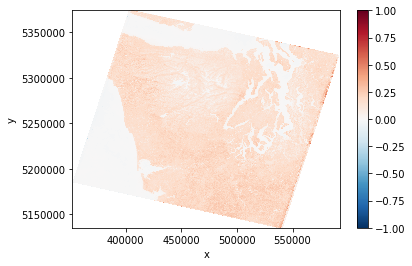

distributed.utils - ERROR - list index out of range
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/distributed/utils.py", line 644, in log_errors
    yield
  File "/opt/conda/lib/python3.6/site-packages/distributed/bokeh/components.py", line 386, in cb
    data = profile.plot_data(self.states[ind], profile_interval)
IndexError: list index out of range


In [25]:
# Plot result
ndvi.plot.imshow()